In [44]:
import os
from gensim.models import Word2Vec
from unidecode import unidecode
import string
from matplotlib import pyplot
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
import multiprocessing
import networkx as nx 
import matplotlib.pyplot as plt
import numpy as np
import nltk



%matplotlib inline

In [6]:
corpus_path = '../data/2019-11-11 09:38:45.985811/filtered_tweets.txt'
graphs_path = '../data/2019-11-11 09:38:45.985811/graphics/'

In [7]:
#importando o corpus
raw_text = ''
with open(corpus_path, 'r') as file:
    raw_text = file.readlines()
    file.close()
    
raw_text = [e.rstrip() for e in raw_text]

print(raw_text[:500])

['bom dia proletariado sulamericano dorme onda progressista america latina acorda golpe militar bolivia reformismo beco saida conciliacao so rabo leiam marx organizem bebam agua boa pa nois golpeenbolivia lulalivre', 'brazilfight vai humilhar stf pois todos membros sao funcionarios particulares lacaios comprados peso ouro tudo acontece la tudo ensaiado combinado antes voce vota assim outro vota assado assim diante artigo142', 'josiasteofilo lula politicos individuos cinicos corruptos mundo steve bannon', '125 dias dnaworldtour brasil backstreetboys ktbspa', 'deputadofederal lava jato moro usaram dinheiro contribuinte brasileiro estrutura estado interferir vida interna', 'themingau fala lula ultimamente resolvi falar lula tambem vou falar lula mamifero lulaofic', 'vergonha nacional continua bom dia brasil chico pinheiro compartilhando gente vergonha', 'anee aesquerda ignorar lindo ver lulalivre', 'alvarodias senadora juiza selma ja entregou relatorio favoravel pec segunda instancia proj

In [21]:
#TF_IDF
vectorizer = TfidfVectorizer()
tfidf_vectors = vectorizer.fit_transform(raw_text)

print(tfidf_vectors.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [22]:
#preparando a lista de palavras
word_list = [e.split(' ') for e in raw_text]

nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('portuguese')
stop_words.extend(["ja", "assim", "nao", "pra", "q", "voce", "sobre","ser", "so", "vai", "ate", "tao", 'so'])

word_list = [ [w for w in e if w not in stop_words] for e in word_list] #filtrando o texto

print(word_list[15])
print("nao" in word_list)

['zehdeabreu', 'homem', 'confianca', 'jair', 'bolsonaro', 'citado', 'audio', 'opositores', 'tentam', 'golpe', 'contra', 'evo', 'bolivia', 'revista']
False


[nltk_data] Downloading package stopwords to /home/natan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
#treinando modelo
model_w2v = Word2Vec(
    word_list, 
    window=5, #vizinhos checados
    min_count= multiprocessing.cpu_count(), 
    workers=5,
    size= 200,
    sg = 0
)

#palavras dentro do modelo
words_in_w2v = list(model_w2v.wv.vocab)[:]


print(model_w2v)
print(words_in_w2v[:30])

Word2Vec(vocab=1304, size=200, alpha=0.025)
['bom', 'dia', 'america', 'latina', 'golpe', 'militar', 'bolivia', 'saida', 'rabo', 'leiam', 'agua', 'boa', 'lulalivre', 'brazilfight', 'stf', 'pois', 'todos', 'sao', 'tudo', 'acontece', 'la', 'antes', 'vota', 'outro', 'lula', 'politicos', 'corruptos', 'mundo', 'steve', 'bannon']


In [29]:
#imprimindo palavras próximas
def print_results(model, *args):
    print(args)
    if len(args) == 1:
        arg = str(*args)
        if arg not in words_in_w2v:
            return print('Error - words out of dict')
        print('Most  common word near is:')
        for e in model_w2v.wv.most_similar(arg)[:10]:
            print(e)
            print('-'*20)
        print('#'*20)
    
    #se for uma frase
    if len(args) > 1:
        print("Further away from the mean: {0}".format(model.wv.doesnt_match(args)))
        if len(args) == 2:
            print("Similarity: {0}".format(model.wv.similarity(args[0], args[1])))
        print('#'*20)


In [30]:
print_results(model_w2v, 'pec')

('pec',)
Most  common word near is:
('lula', 0.5013201236724854)
--------------------
('moro', 0.4724885821342468)
--------------------
('410', 0.4605793356895447)
--------------------
('morales', 0.4602895975112915)
--------------------
('stf', 0.4535052180290222)
--------------------
('presidente', 0.4525757431983948)
--------------------
('instancia', 0.4488009214401245)
--------------------
('brasil', 0.446178674697876)
--------------------
('apos', 0.4276982247829437)
--------------------
('lava', 0.4274693727493286)
--------------------
####################


In [31]:
print_results(model_w2v, 'dilma', 'paulo')

('dilma', 'paulo')
Further away from the mean: dilma
Similarity: 0.12049423903226852
####################


In [34]:
#preparando dados para gráfico

search_key = 'presidente'
embeddings, words = [], []

for similar_word, _ in model_w2v.most_similar(search_key):        
    words.append(similar_word)
    embeddings.append(model_w2v[similar_word])
    
print(words)

embeddings = np.array(embeddings)
print(embeddings.shape)

['stf', 'lula', 'prisao', 'lava', 'esquerda', 'vaza', 'moro', 'porque', 'sao', 'jato']
(10, 200)


/home/natan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/home/natan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


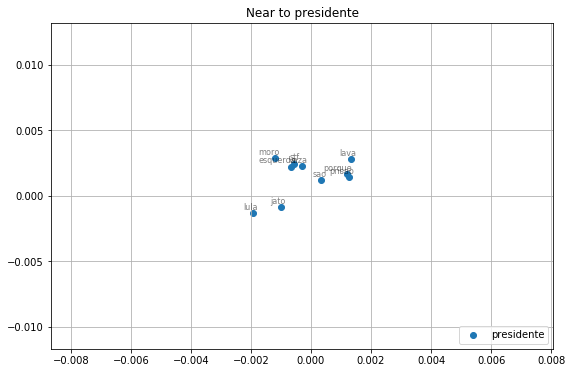

In [35]:
tsne_model_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=600, random_state=3)

embeddings_2d = np.array(tsne_model_2d.fit_transform(embeddings))

plt.figure(figsize=(9, 6))
x = embeddings[:, 0]
y = embeddings[:, 1]
plt.scatter(x, y, label = search_key)

for i, e in enumerate(words):
    plt.annotate(e, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom', size=8)

plt.legend(loc=4)
plt.title('Near to {0}'.format(search_key))
plt.grid(True)
plt.savefig(graphs_path+'_tnse'+search_key+'.png', format='png', dpi=200)

plt.show()

/home/natan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  del sys.path[0]
/home/natan/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


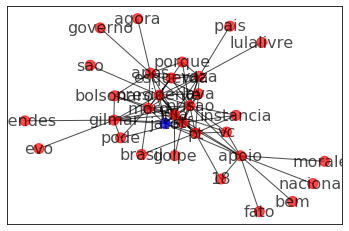

In [36]:
#grafico de rede
net_term = 'jato'
net_graph = nx.Graph()

net_graph.add_node(net_term)

neigbors = model_w2v.wv.most_similar(net_term) #vizinhos

net_graph.add_weighted_edges_from([(net_term, x, y) for x,y in neigbors if y> 0.5] )

#adicionando vizinhos e mostrando relações indiretas
for e in neigbors:
    net_graph.add_weighted_edges_from([(e[0], x, y) for x,y in model_w2v.most_similar(e[0])])

cols = ['r']*len(net_graph.nodes()); cols[list(net_graph.nodes()).index(net_term)]='b'
pos = nx.spring_layout(net_graph, iterations=100)


nx.draw_networkx(
    net_graph,
    pos=pos, #posições
    node_color=cols, #cores
    node_size=100, #tamanho do marcador
    alpha=0.7, 
    font_size=16,
)

In [45]:
#Modelo Glove

OSError: [E050] Can't find model 'pt_core_news_sm'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.